# IPTA SW 2025 GW analysis **SETUP**

## intro

This notebook will walk you through setting up a simple GW analysis using `enterprise`.

The data used here are simulated observations of 12 pulsars based on NANOGrav's 15yr data release, which is part of the IPTA-DR3 data combination.

There is a companion notebook `gw_analysis_ACTIVITY.ipynb`, which contains several suggestions for other analyses to try.
Multiple team members can each try a different analysis option to run overnight.
Then you can compare your results in later work sessions.

## load useful software

`enterprise` contains tools to construct a data model to use in a Bayesian PTA analysis.

`enterprise_extensions` provides common recipes to simplify the construction of your data model.

We're going to use several tools from the `enterprise.signal` module, and also show the equivalent way to use `enterprise_extensions`.

In [1]:
import os
import numpy as np

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import gp_signals
from enterprise.signals import gp_bases
from enterprise.signals import selections
from enterprise.signals import utils
from enterprise.signals import white_signals
from enterprise.signals import deterministic_signals

from enterprise_extensions.chromatic.solar_wind import solar_wind_block

# we won't use these, but you'll need them to do things the "e_e" way
from enterprise_extensions.load_feathers import load_feathers_from_folder
from enterprise_extensions.model_utils import get_tspan
from enterprise_extensions import blocks

/opt/build_psrsoft/workspace/micromamba/envs/IPTA_Env/lib/python3.12/site-packages/enterprise/signals/utils.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import Requirement, resource_filename
libstempo not installed. PINT or libstempo are required to use par and tim files.
Matplotlib is building the font cache; this may take a moment.


## Load simulated data

`enterprise.Pulsar` objects begin by loading data from `par`/`tim` files.

After they are built it is convenient to save the instantiated objects as `feather` files.  The `feather`s we are using also contain a dictionary of noise parameters that we will use to hold the white noise fixed during the GW analysis.

In [2]:
# get our paths ready and load the list of pulsars
basedir = os.path.abspath(".")
datadir = os.path.join(basedir, "sim_data_gwb")

with open(os.path.join(datadir, "psrlist.txt"), "r") as f:
    psrlist = [line.strip() for line in f.readlines()]

In [3]:
psrs = [Pulsar(os.path.join(datadir, pp+".feather")) for pp in psrlist]

FeatherPulsar.read_feather: cannot find dmx in feather file /home/pulsar/SHARE/ipta_2025_GWA_activity/sim_data_gwb/J0030+0451.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file /home/pulsar/SHARE/ipta_2025_GWA_activity/sim_data_gwb/J0613-0200.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file /home/pulsar/SHARE/ipta_2025_GWA_activity/sim_data_gwb/J1012+5307.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file /home/pulsar/SHARE/ipta_2025_GWA_activity/sim_data_gwb/J1455-3330.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file /home/pulsar/SHARE/ipta_2025_GWA_activity/sim_data_gwb/J1600-3053.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file /home/pulsar/SHARE/ipta_2025_GWA_activity/sim_data_gwb/J1744-1134.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file /home/pulsar/SHARE/ipta_2025_GWA_activity/sim_data_gwb/J1832-0836.feather.
FeatherPulsar.read_feather: cannot find dmx in feather 

It's okay that these pulsars don't have DMX data... the IPTA doesn't use the DMX model!

There's also an `e_e` function to do this, which we loaded above...

```python
psrs = load_feathers_from_folder(datadir, psrlist)
```

To set the sampling frequencies for our Fourier domain GP models, we need to know the total time span of the data.
We can figure this out manually or using an `e_e` function.

```python
Tspan = get_tspan(psrs)
```

In [4]:
Tmin = np.min([pp.toas.min() for pp in psrs])
Tmax = np.max([pp.toas.max() for pp in psrs])

Tspan = Tmax - Tmin

# Build the `enterprise.PTA` object

In `enterprise` first you specify the data **model**.
The model is comprised of several **signals** that account for different effects in the data.

Every pulsar has a **timing model** from its `.par` file.
The best fit timing model has uncertainty that we will marginalize over.
We will use a "vanilla" noise model consisting of **white noise**, intrinsic pulsar **red noise**, and dispersion measure (**DM**) variations.
Finally, there is a global **gravitational wave** signal affecting all pulsars.
Each of these components is defined in our code individually.

Let's start with the timing model.

In [5]:
# timing model
tm = gp_signals.MarginalizingTimingModel(use_svd=True)

The **white noise** model has three parameters, which are held fixed for GW analysis.
So they are all `Constant` parameters.

We can do this using `e_e` too:
```python
wn = blocks.white_noise_block(
    vary=False, 
    select="backend",
    inc_ecorr=True,
    ecorr_select="channelized",
)
```

In [6]:
# white noise (EFAC, EQUAD, ECORR)
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant()

# use built-in backend selection, since all NG backends need ECORR
backend = selections.Selection(selections.by_backend)

# make EFAC/EQUAD white noise "signal"
wn = white_signals.MeasurementNoise(
    efac=efac,
    log10_t2equad=equad,
    selection=backend
)

# make ECORR "signal" and add it to the existing WN signal
wn += white_signals.EcorrKernelNoise(
    log10_ecorr=ecorr,
    selection=backend
)

The standard **red noise** model has two parameters for the amplitude and spectral index of the noise's powerlaw  PSD.  It is a Fourier domain gaussian process (GP) model.  The two parameters have `Uniform` priors which we specify by the choice of `enterprise.parameter`.

There is of course an `e_e` one-liner:
```python
blocks.red_noise_block(components=30, Tspan=Tspan)
```

In [7]:
# PSR red noise "signal"
rn_logA = parameter.Uniform(-20, -11)
rn_gamma = parameter.Uniform(0,7)

pl_spect = utils.powerlaw(log10_A=rn_logA, gamma=rn_gamma)
rn = gp_signals.FourierBasisGP(
    pl_spect,
    components=30,
    Tspan=Tspan,
    name="red_noise",
)

The standard **DM variations** model is also a powerlaw spectrum, Fourier domain GP.  It's often refered to as **DM GP**.

Since the DM variations often have a flatter spectrum than the red noise, they require more Fourier components to ensure they cover higher frequencies.

In `e_e` it's:
```python
dm = blocks.dm_noise_block(components=100, Tspan=Tspan)
```

In [8]:
# DM GP "signal"
log10_A_dm = parameter.Uniform(-20, -11)
gamma_dm = parameter.Uniform(0,7)

dm_prior = utils.powerlaw(log10_A=log10_A_dm, gamma=gamma_dm)
dm_basis = utils.createfourierdesignmatrix_dm(nmodes=100, Tspan=Tspan)
dm = gp_signals.BasisGP(
    dm_prior,
    dm_basis,
#    combine=False,
#    coefficients=False,
    name="dm_gp",
)

The **solar wind** model is more complicated than the others to set up,
especially if we use an astrophysical prior on the soloar wind's electron density...
let's just use `e_e`

In [9]:
# solar wind model via enterprise_extensions
sw = solar_wind_block(ACE_prior=True, include_swgp=False)

Finally, our **GW model** is another Fourier basis GP, but this time it is common to all pulsars.
We tell `enterprise` this by instantiating the `parameter` objects with names.
Here well hold the spectral index constant at 13/3 and only vary the amplitude.

The GW model usually uses fewer Fourier components, since it is only dominant in the lowst frequency Fourier bins.

We're going to test with a common uncorrelated red noise (CURN or CRN) model for our GWs instead of the more computationally expensive, but correct, Hellings-Downs (HD) correlated model.

Or we can just use `e_e`...
```python
gw = blocks.common_red_noise_block(
    components=15,
    orf="crn",
    logmin=-18, logmax=-13,
    gamma_val=13/3,
    Tspan=Tspan,
    name="gwb"
)
```

If we wanted to use an HD correlated model, we would change the overlap reduction function, `orf`, keyword argument in the `e_e` function above.

It's a bit more complicated to make the change using raw enterprise.
This requires using `gp_signals.BasisCommonGP()` and passing it an ORF function, like `utils.hd_orf`.

(the uncorrelated CRN model gets away with the simpler `gp_signals.BasisGP()`, because there are no off-diagonal, cross terms in the pulsar correlation matrix)

In [10]:
# GWB signal
gw_logA = parameter.Uniform(-18, -13)("gw_log10_A")
gw_gamma = parameter.Constant(4.333)("gw_gamma")

gw_spect = utils.powerlaw(log10_A=gw_logA, gamma=gw_gamma)
gw_basis = gp_bases.createfourierdesignmatrix_red(nmodes=15, Tspan=Tspan)
gw = gp_signals.BasisGP(gw_spect, gw_basis, name="gwb")

To instantiate a `PTA` object we need a model and a pulsar object (or a list of each).

The full data model, `s`, is the sum of all of the individual **signals** we defined above.

Then we apply the data model to each pulsar object to get a list of `models`.

Finally, we instantiate a `PTA` object using that list.

In [11]:
s = tm + wn + rn + dm + sw + gw
models = [s(pp) for pp in psrs]
pta = signal_base.PTA(models)

The last thing to do is tell the `PTA` about the white noise parameters we are holding fixed.
This is done using a dictionary, which is sometimes loaded from a `.json` file.
In our case each `FeatherPulsar` object already has it's own noise dictionary we can use.

In [12]:
full_noisedict = {}
for pp in psrs:
    full_noisedict.update(pp.noisedict)

pta.set_default_params(full_noisedict)

To test things, let's calculate the log-likelihood and log-prior probabilities for a set of random parameters drawn from their priors.

In [13]:
# make a parameter vector as a dictionary
x0 = {pp.name:pp.sample() for pp in pta.params}

# calculate logL and logPrior
print(pta.get_lnlikelihood(x0), pta.get_lnprior(x0))

2543887.6616103915 -102.83168222618082


We can output a summary of our data model to see what we are working with.
It's common to save this information (and some other metadata) to file before starting the MCMC run.

Note that after setting the "default parameters" with our noise dictionary all of the `Constant` WN parameters have values.

In [14]:
print(pta.summary())

enterprise v3.4.4,  Python v3.12.0

Signal Name                              Signal Class                   no. Parameters      
J0030+0451_marginalizing_linear_timing_model TimingModel                    0                   

params:
__________________________________________________________________________________________
J0030+0451_measurement_noise             MeasurementNoise               0                   

params:
J0030+0451_430_ASP_efac:Constant=1.1205547935388698                                       
J0030+0451_430_ASP_log10_t2equad:Constant=-7.092545216066928                              
J0030+0451_430_PUPPI_efac:Constant=1.0580395226107853                                     
J0030+0451_430_PUPPI_log10_t2equad:Constant=-6.999669460973212                            
J0030+0451_L-wide_ASP_efac:Constant=1.1323319918510732                                    
J0030+0451_L-wide_ASP_log10_t2equad:Constant=-7.528897742548894                           
J0030+0451_L-wide_PUPPI_ef

At the very end we see that there are $50$ varying parameters:
 * $1$ GWB amplitude
 * $1$ SW density
 * $2$ RN amplitude and spectral index (per pulsar, so $2\cdot 12 =24$ total)
 * $2$ DMGP amplitude and spectral index (per pulsar, so $24$ total)

The $24$ common parameters are the GWB amplitude and the SW density (duplicated across each pulsar, so it's really only $2$ independent parameters)

## Setup and run a short MCMC

In [15]:
from enterprise_extensions import sampler

There are a lot of interesting things we can do to tweak our sampler setup to get better efficiency, but we're just going to use a convenient and generic setup from `e_e`...

The `setup_sampler` method will save metadata, like the `pta_summary` to file.  You can pass your name or initials to the `human` keyword argument to keep track of who did what.

**Make sure to save your output to a shared directory on your local machine!!!**

In [16]:
# specify the output directory
outdir = "mcmc_test"

In [17]:
# setup the sampler
sampler = sampler.setup_sampler(pta, outdir=outdir, human="AName", resume=False)

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding GWB uniform distribution draws...



We already have an initial sample from above, but it is a dictionary.
`PTMCMCSampler` requires an input `numpy.array`.
We can easily build one by stacking the values of our dictionary.

In [18]:
# generate an initial sample
p0 = np.hstack(list(x0.values()))

When running a sampler we must specify how many samples to collect.

`PTMCMCSampler` has two inputs that affect this:
 * `Niter` -- the number of iterations to run
 * `thin` -- the factor by which to thin your samples

If you want $2000$ samples saved in your chain and want to thin by a factor of two (keep every other sample), then you actually need to run for $2\cdot 2000 = 4000$ iterations.

Finally, `burn` is a misnomer.
Some features of the sampler don't turn on right away, but wait until after the "burn in" when the chain is more stable.
This sets how long to wait.
In this case the differential evolution `DE` moves will turn on after $1000$ iterations or $25\%$ of our total run.
The earlier samples are still saved, and you can choose your own burn in length later when making inferences using your samples.

This run won't be useful... but it should finish in a few minutes.

In [19]:
B = 1_000
T = 2
Nsamp = 2_000

N = 2*Nsamp

sampler.sample(
    p0,
    Niter=N,
    burn=B,
    thin=T
)

Finished 0.00 percent in 0.279236 s Acceptance rate = 0

/opt/build_psrsoft/workspace/micromamba/envs/IPTA_Env/lib/python3.12/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 25.00 percent in 534.154022 s Acceptance rate = 0.564Adding DE jump with weight 20
Finished 100.00 percent in 2192.105636 s Acceptance rate = 0.40625
Run Complete


Finally, we can take a peak inside the collected samples.
In practice it's usually better to work with the saved output, which can be accessed while the sampler is still running, instead of waiting until the job completes.

In [20]:
from matplotlib import pyplot as plt

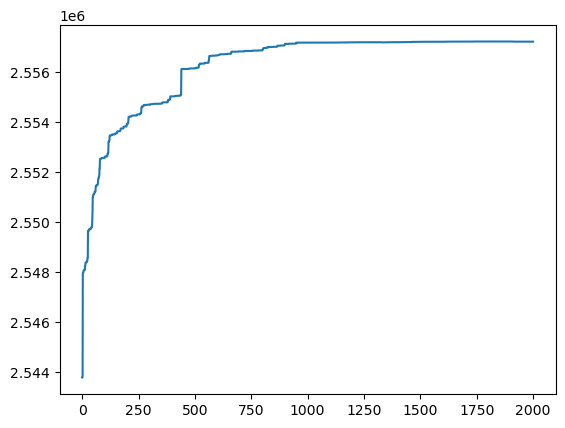

In [21]:
burn = 0  # try setting burn to cut off the early part, when logP is still growing rapidly
plt.plot(sampler._lnprob[burn:])

This will plot a trace of the GW log-amplitude parameter, using whatever `burn` you set above?

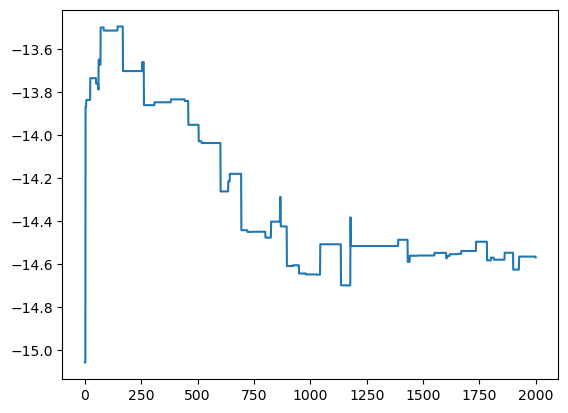

In [22]:
ii = pta.param_names.index("gw_log10_A")

plt.plot(sampler._chain[burn:, ii])

# Your assignment

Keep this notebook open, and open the  `gw_analysis_ACTIVITY.ipynb` notebook in a new tab...

You will set up your own more thorough analysis using one of the simulated data sets!